**Table of contents**<a id='toc0_'></a>    
1. [多继承](#toc1_)    
1.1. [多继承的语法](#toc1_1_)    
1.2. [同名函数的继承问题](#toc1_2_)    
2. [描述符](#toc2_)    
2.1. [类属性定义时的麻烦](#toc2_1_)    
2.2. [描述符的规定](#toc2_2_)    
2.3. [实例演示](#toc2_3_)    
3. [\_\_new__方法](#toc3_)    
3.1. [函数动态参数列表](#toc3_1_)    
3.2. [\_\_new__方法的定义原型](#toc3_2_)    
3.3. [\_\_new__方法的执行时刻](#toc3_3_)    
3.4. [\_\_new__方法的最佳实践](#toc3_4_)    
4. [异常类](#toc4_)    
4.1. [常用的异常类继承关系](#toc4_1_)    
4.2. [异常类的捕捉](#toc4_2_)    
4.3. [同时处理多个异常](#toc4_3_)    
4.4. [raise异常](#toc4_4_)    
4.5. [自定义异常](#toc4_5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[多继承](#toc0_)
---
## 1.1. <a id='toc1_1_'></a>[多继承的语法](#toc0_)


In [1]:
class A:
    def render(self):
        print("A")


class B:
    def hello(self):
        print("hello B")


class C(A, B):
    pass


c = C()
c.render()
c.hello()

A
hello B


## 1.2. <a id='toc1_2_'></a>[同名函数的继承问题](#toc0_)

按照继承的顺序调用首先出现的函数

In [2]:
class A:
    def render(self):
        print("A")


class B:
    def render(self):
        print("B")

    def hello(self):
        print("hello B")


class C(A, B):
    pass


c = C()
c.render()
c.hello()

A
hello B


In [5]:
class A:
    def render(self):
        print("A")


class B:
    def render(self):
        print("B")

    def hello(self):
        print("hello B")


class C(B, A):
    pass


c = C()
c.render()
c.hello()

B
hello B


指定要执行哪个父类的函数

In [6]:
class A:
    def render(self):
        print("A")

    def hello(self):
        print("hello A")


class B:
    def render(self):
        print("B")

    def hello(self):
        print("hello B")


class C(B, A):
    def hello(self):
        # super().hello() #! 这样还是无法指定
        A.hello(self)

    def render(self):
        A.render(self)


c = C()
c.render()
c.hello()

A
hello A


# 2. <a id='toc2_'></a>[描述符](#toc0_)
---
## 2.1. <a id='toc2_1_'></a>[类属性定义时的麻烦](#toc0_)

相同的逻辑判断，需要写两遍甚至多遍。

In [13]:
class Student1:
    def __init__(self, first_name: str, last_name: str) -> None:
        self.first_name = first_name
        self.last_name = last_name

    @property
    def first_name(self) -> str:
        return self.__first_name

    @first_name.setter
    def first_name(self, first_name: str):
        if not isinstance(first_name, str):
            raise ValueError("First name must be a string")
        if not first_name:
            raise ValueError("First name must not be empty")
        self.__first_name = first_name

    @property
    def last_name(self) -> str:
        return self.__last_name

    @last_name.setter
    def last_name(self, last_name: str):
        if not isinstance(last_name, str):
            raise ValueError("Last name must be a string")
        if not last_name:
            raise ValueError("Last name must not be empty")
        self.__last_name = last_name


s = Student1("Jack", "M")
print(s.first_name)
s.first_name = "alice"
print(s.first_name)
# s.first_name=1
# s.first_name=''
# print(s.first_name) #! First name must not be empty
s.last_name = ""
print(s.last_name)  #! Last name must not be empty

Jack
alice


ValueError: Last name must not be empty

## 2.2. <a id='toc2_2_'></a>[描述符的规定](#toc0_)

描述符是一个特殊的类，要求实现如下一些方法

- \_\_set_name__(self,owner,name)
- \_\_get__(self,instance,owner)
- \_\_set__(self,instance,value)
- \_\_delete__(self,instance)

In [50]:
class RequireString:
    def __init__(self, trim=False):
        self.__trim = trim

    def __set_name__(self, owner, name):
        self.__property_name = name

    def __get__(self, instance, owner):
        if self.__property_name in instance.__dict__:
            return instance.__dict__[self.__property_name]
        return None

    def __set__(self, instance, value):
        if not isinstance(value, str):
            raise TypeError(f"{self.__property_name} must be a string")
        if self.__trim and not value.strip():
            raise ValueError(f"{self.__property_name} must be not empty")
        instance.__dict__[self.__property_name] = value


class Student:
    first_name = RequireString(True)
    last_name = RequireString(True)
    password = RequireString()

    def __str__(self):
        return f"{self.first_name} {self.last_name} : {self.password}"


s1 = Student()
s2 = Student()

s1.first_name = "Jack"
s1.last_name = "M"
print(s1)

s2.password = "1"
print(s2.first_name)

s2.first_name = "  "
print(s2)

Jack M : None
None


ValueError: first_name must be not empty

## 2.3. <a id='toc2_3_'></a>[实例演示](#toc0_)

In [51]:
%%writefile AbstractValidator.py
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
"""
@File    :   面向对象编程VI.ipynb
@Time    :   2023/01/10 21:27:37
@Author  :   owl
@Email   :   xxxxx@163.com
@Desp    :   验证器是一个用于托管属性访问的描述器。在存储任何数据之前，它会验证新值是否满足各种类型和范围限制。如果不满足这些限制，它将引发异常，从源头上防止数据损坏。
这个 Validator 类既是一个 abstract base class 也是一个托管属性描述器。
"""

# here put the import lib
from abc import ABC, abstractmethod


class Validator(ABC):
    def __set_name__(self, owner, name):
        self.private_name = f"_{name}"

    def __get__(self, obj, objtype=None):
        return getattr(obj, self.private_name)

    def __set__(self, obj, value):
        self.validate(value)
        setattr(obj, self.private_name, value)

    @abstractmethod
    def validate(self, value):
        pass

Writing AbstractValidator.py


In [52]:
%%writefile CustomValidator.py
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
"""
@File    :   面向对象编程VI.ipynb
@Time    :   2023/01/10 21:28:57
@Author  :   owl
@Email   :   xxxxx@163.com
@Desp    :   自定义验证器需要从 Validator 继承，并且必须提供 validate() 方法以根据需要测试各种约束。
"""

# here put the import lib
from AbstractValidator import Validator

"""
这是三个实用的数据验证工具：

1. OneOf 验证值是一组受约束的选项之一。

2. Number 验证值是否为 int 或 float。根据可选参数，它还可以验证值在给定的最小值或最大值之间。

3. String 验证值是否为 str。根据可选参数，它可以验证给定的最小或最大长度。它还可以验证用户定义的 predicate。
"""


class OneOf(Validator):
    def __init__(self, *options):
        self.options = set(options)

    def validate(self, value):
        if value not in self.options:
            raise ValueError(f"Expected {value!r} to be one of {self.options!r}")


class Number(Validator):
    def __init__(self, minvalue=None, maxvalue=None):
        self.minvalue = minvalue
        self.maxvalue = maxvalue

    def validate(self, value):
        if not isinstance(value, (int, float)):
            raise TypeError(f"Expected {value!r} to be an int or float")
        if self.minvalue is not None and value < self.minvalue:
            raise ValueError(f"Expected {value!r} to be at least {self.minvalue!r}")
        if self.maxvalue is not None and value > self.maxvalue:
            raise ValueError(f"Expected {value!r} to be no more than {self.maxvalue!r}")


class String(Validator):
    def __init__(self, minsize=None, maxsize=None, predicate=None):
        self.minsize = minsize
        self.maxsize = maxsize
        self.predicate = predicate

    def validate(self, value):
        if not isinstance(value, str):
            raise TypeError(f"Expected {value!r} to be an str")
        if self.minsize is not None and len(value) < self.minsize:
            raise ValueError(
                f"Expected {value!r} to be no smaller than {self.minsize!r}"
            )
        if self.maxsize is not None and len(value) > self.maxsize:
            raise ValueError(
                f"Expected {value!r} to be no bigger than {self.maxsize!r}"
            )
        if self.predicate is not None and not self.predicate(value):
            raise ValueError(f"Expected {self.predicate} to be true for {value!r}")



Writing CustomValidator.py


In [53]:
%%writefile PracticalApplication.py
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
"""
@File    :   面向对象编程VI.ipynb
@Time    :   2023/01/10 21:33:05
@Author  :   owl
@Email   :   xxxxx@163.com
@Desp    :   这是在真实类中使用数据验证器的方法：
"""

# here put the import lib
from CustomValidator import *


class Component:

    name = String(minsize=3, maxsize=10, predicate=str.isupper)
    kind = OneOf("wood", "metal", "plastic")
    quantity = Number(minvalue=0)

    def __init__(self, name, kind, quantity):
        self.name = name
        self.kind = kind
        self.quantity = quantity


Component("Widget", "metal", 5)
Component("WIDGET", "metle", 5)
Component("WIDGET", "metal", -5)
Component("WIDGET", "metal", "V")
c = Component("WIDGET", "metal", 5)

Writing PracticalApplication.py


# 3. <a id='toc3_'></a>[\_\_new__方法](#toc0_)

## 3.1. <a id='toc3_1_'></a>[函数动态参数列表](#toc0_)

In [1]:
def excute(*args, **kwargs):
    print(args)
    print(kwargs)


excute("abc")
excute("abc", "def")
excute("abc", 12)
excute("abc", 34, name="Tom", age=18)

('abc',)
{}
('abc', 'def')
{}
('abc', 12)
{}
('abc', 34)
{'name': 'Tom', 'age': 18}


## 3.2. <a id='toc3_2_'></a>[\_\_new__方法的定义原型](#toc0_)

该方法定义在object类当中，所有类的最终父类都是object类

## 3.3. <a id='toc3_3_'></a>[\_\_new__方法的执行时刻](#toc0_)

构造一个对象的过程，比如：

    person = Person("Jack")
    1. person = object.__new__(Person,"Jack")
    2. person.__init__("Jack")

## 3.4. <a id='toc3_4_'></a>[\_\_new__方法的最佳实践](#toc0_)

也就是在说明情况下使用__new__，以及怎么用。</br>
通常情况下定义了__new__就不用再定义__init__方法了。

In [4]:
class SquareNumber(int):
    def __new__(cls, value: int):
        return super().__new__(cls, value**2)


num = SquareNumber(2)
print(num)
print(type(num))
print(isinstance(num, int))

4
<class '__main__.SquareNumber'>
True


In [6]:
class Student:
    def __new__(cls, first_name, last_name):
        obj = super().__new__(cls)
        obj.first_name = first_name
        obj.last_name = last_name
        return obj


student = Student("Jack", "M")
print(student.first_name, student.last_name)

Jack M


# 4. <a id='toc4_'></a>[异常类](#toc0_)
---
## 4.1. <a id='toc4_1_'></a>[常用的异常类继承关系](#toc0_)
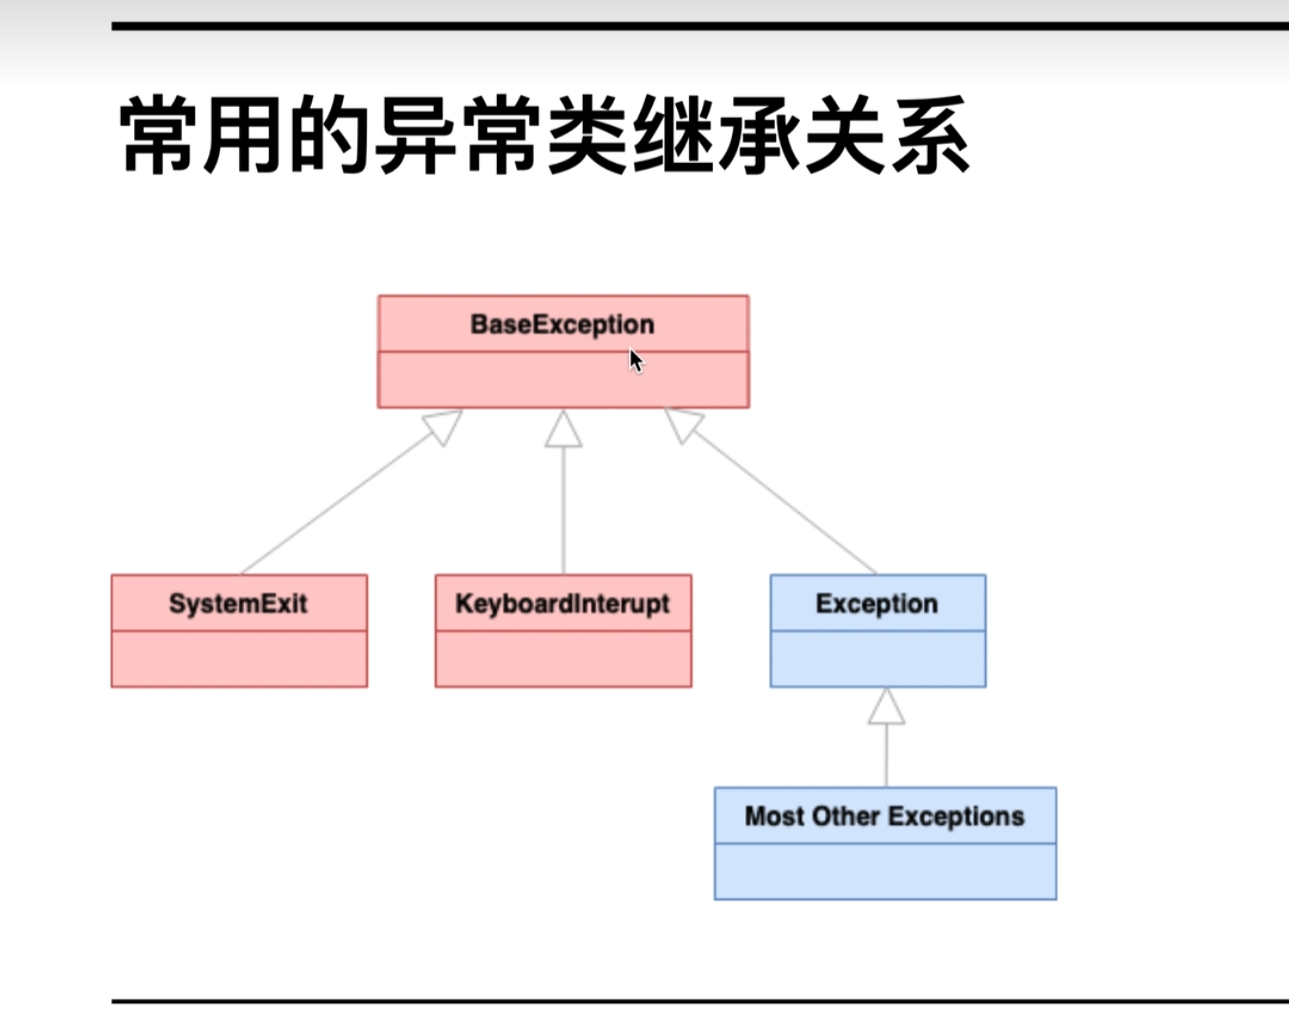


## 4.2. <a id='toc4_2_'></a>[异常类的捕捉](#toc0_)

在 try...except...语句中，可以使用特定的异常类来捕捉错误，也可以使用父类型的异常类来捕捉。

In [9]:
try:
    num = 2
    s = 0
    res = num / s
    print(res)
except ZeroDivisionError as e:
    print("ZeroDivisionError")

ZeroDivisionError


In [8]:
try:
    num = 2
    s = 0
    res = num / s
    print(res)
except ArithmeticError as e:
    print("ArithmeticError")

ArithmeticError


## 4.3. <a id='toc4_3_'></a>[同时处理多个异常](#toc0_)

在同时捕捉多个异常的时候，需要先捕捉子类型的异常，后捕捉夫类型的异常。

In [10]:
try:
    num = 2
    s = 0
    res = num / s
    print(res)
except ArithmeticError as e:
    print("ArithmeticError")
except ZeroDivisionError as e:
    print("ZeroDivisionError")

ArithmeticError


In [11]:
try:
    num = 2
    s = 10
    res = num / s
    print(res)
    names = (1, 2)
    print(names[3])
except ZeroDivisionError as e:
    print("ZeroDivisionError")
except Exception as e:
    print("Exception")

0.2
Exception


## 4.4. <a id='toc4_4_'></a>[raise异常](#toc0_)

可以在代码中通过raise异常的方式来向调用者返回错误信息。

In [12]:
def add(n1, n2):
    if not isinstance(n1, int) or not isinstance(n2, int):
        raise Exception("Argument must be int")
    return n1 + n2


try:
    add("1", "2")
except Exception as e:
    print(f"Exception : {e}")

Exception : Argument must be int


## 4.5. <a id='toc4_5_'></a>[自定义异常](#toc0_)

In [13]:
class InvalidArgumentException(Exception):
    def __init__(self, *args):
        super().__init__(args)


def add(n1, n2):
    if not isinstance(n1, int) or not isinstance(n2, int):
        raise InvalidArgumentException("Argument must be int")
    return n1 + n2


try:
    add("1", "2")
except InvalidArgumentException as e:
    print(f"InvalidArgumentException : {e}")
except Exception as e:
    print(f"Exception : {e}")

InvalidArgumentException : ('Argument must be int',)
